In [1]:
# Importing the modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams.update({'font.serif':'Arial', 'font.size': 15.0, 
                     'xtick.labelsize': 15, 'ytick.labelsize': 15,
                    'legend.fontsize':15,
                    'figure.dpi': 80.0, 'figure.figsize': [9, 5]})

In [3]:
def read_data(filename, sort_by):
    with open(filename, "r") as file:   # jid=253256
        lines = file.readlines()
        header = lines[8].split()[2:]
        timestep = int(lines[1].split()[0])
        natom = int(lines[3].split()[0])
        dump_top = lines[0:8]
#         print('Header\n', header)
        total_lines = len(lines)
        print('Total lines:', total_lines)

        # Reading the data:
        data = np.array([list(map(float, line.strip().split())) for line in lines[dump_offset:]])
        
        # Sorting the data according to position:
        sorted_index = np.argsort(data[:, sort_by])
        data = data[sorted_index]
    return dump_top, natom, header, data


In [6]:
# Reading the fingerprint data:
fingerprint = pd.read_csv('fingerprint.dat', header = None, delimiter='\t')
CNrescale = 10                             # Value used to rescale coordination number
# Dataformat:
# Rows: Q1-Q12 and CN-Co, Si, O
fingerprint.iloc[12:] /= CNrescale
total_col = fingerprint.shape[1]

#Reading the dumpfile:
Temp = 1100
MD_str=f'./dump_aveSOP_{Temp}K.lmc'

dump_offset = 9

dump_top, natom, header, data = read_data(MD_str, 0)   # Data sorted by atom type

data[:, -4:] = data[:, -4:]/CNrescale        # Rescaling the coordination number 

Total lines: 16907


In [7]:
# Calculating the L1 norm:
new_data = []

for i in np.arange(natom):
#     print(data[i, 1] == 1)
    if data[i, 1] == 1:  # Co ref
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(0, total_col, 3)])   # 0 = Co of chiral
    if data[i, 1] == 2:  # Si ref
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(1, total_col, 3)])   # 1 = Si of chiral
    if data[i, 1] == 3:  # O ref 
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(2, total_col, 3)])   # 2 = O of chiral
    if data[i, 1] == 4:  # Si ref
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(1, total_col, 3)])   # 1 = Si of chiral

In [8]:
# Converting to pandas dataframe:
title1 = ['v_normCoSi', 'v_normACoSi', 'v_normCo2Si', 'v_normCoSi2', 'v_Co', 'v_Si', 'v_SiO2']
new_data = pd.DataFrame(new_data, columns = title1)

# Now combine with position
title2 = ['ITEM: ATOMS id', 'type', 'x', 'y', 'z']
pos_data = pd.DataFrame(data[:, 0:5], columns = title2)

df_combined_data = pd.concat([pos_data, new_data], axis=1)
df_combined = np.array(df_combined_data)

#-----------------------------------------------------------#
# Write the datafile:
new_dump = f'{file_loc}/dump_norm_{Temp}.lmp'

with open(new_dump, "w") as output_file:
    
# Writing the structural details, natoms, box size
    for i in dump_top:
        output_file.write(i)
    
#     output_file.write('\n')
    combined_list = title2 + title1

    for i in range(len(combined_list)):
        output_file.write(combined_list[i] + '\t')
    
    output_file.write('\n')
    
    for item in df_combined:
        output_file.write(str(int(item[0]))+ '\t' + '\t'.join(str(elem) for elem in item[1:]) + '\n')

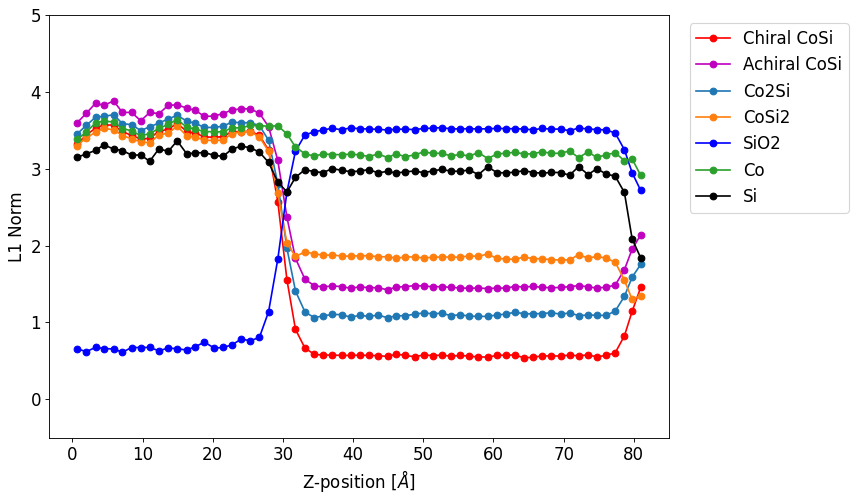

In [9]:
# reading the processed dump:
sorted_df = df_combined_data.sort_values(by=['z'])
min_val = sorted_df['z'].min()            # min z-value
max_val = sorted_df['z'].max()            # max z-value
sorted_df['z']= sorted_df['z']- min_val   # Rescaling the z-position

# print(sorted_df)

diff = 1.3
zlength = sorted_df['z'].max() + 1        # Z-axis box length

ranges = [(i*diff, (i+1)*diff) for i in range(int(np.round(zlength/diff)))]

# print(ranges)
# Calculate averages:
averages = {}

for start, end in ranges:
    group_df = sorted_df[sorted_df['z'].between(start, end)]
#     print(group_df)
    averages[(start, end)] = group_df.mean(numeric_only=True)
    
df_averages = pd.DataFrame(averages).T

# Plotting the data:
fig = plt.figure(figsize=(10,7))
plt.plot(df_averages['z'], df_averages['v_normCoSi'], 'or-', label='Chiral CoSi')
plt.plot(df_averages['z'], df_averages['v_normACoSi'], 'om-', label='Achiral CoSi')
plt.plot(df_averages['z'], df_averages['v_normCo2Si'], 'o-', label='Co2Si')
plt.plot(df_averages['z'], df_averages['v_normCoSi2'], 'o-', label='CoSi2')
plt.plot(df_averages['z'], df_averages['v_SiO2'], 'ob-', label='SiO2')
plt.plot(df_averages['z'], df_averages['v_Co'], 'o-', label='Co')
plt.plot(df_averages['z'], df_averages['v_Si'], 'ok-', label='Si')
plt.ylim(-0.5, 5)
# plt.xlim(-5, 69)
# plt.xlim(-0.5, 5)
plt.xlabel('Z-position [$\AA$]')
plt.ylabel('L1 Norm')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
# plt.savefig(f"{file_loc}/L1_norm_averaging_{Temp}.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()

df_averages.to_csv(f"{file_loc}/L1_Norm_data_{Temp}.dat", index=False)

In [11]:
# In order to average the data witing 40-70 Angstrom 
# you might need to change [25:39]

print(df_averages[25:39].mean())


ITEM: ATOMS id    16327.863080
type                  1.498789
x                    25.651721
y                    25.677988
z                    41.608983
v_normCoSi            0.579029
v_normACoSi           1.468746
v_normCo2Si           1.092533
v_normCoSi2           1.865529
v_Co                  3.180765
v_Si                  2.966803
v_SiO2                3.507470
dtype: float64
